In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

# Set styling
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")

In [2]:
# Load Scaler
scaler = joblib.load('scaler.pkl')

# Load all 5 Brains
models = {
    "KNN": joblib.load('knn_model.pkl'),
    "Logistic Regression": joblib.load('logistic_model.pkl'),
    "SVM": joblib.load('svm_model.pkl'),
    "Naive Bayes": joblib.load('nb_model.pkl'),
    "Neural Network": joblib.load('nn_model.pkl')
}

# Load Data (The 20% Test Set)
df = pd.read_csv('../data/processed/final_model_ready_data.csv')
features = ['HTP', 'ATP', 'HTGD', 'ATGD', 'DiffPts', 'HTFormPts', 'ATFormPts', 'B365H', 'B365D', 'B365A']

# Re-create the 80/20 split to get the same test set
split_idx = int(len(df) * 0.8)
test_df = df.iloc[split_idx:].copy()

X_test = test_df[features]
y_test = test_df['FTR_Binary']
X_test_scaled = scaler.transform(X_test)

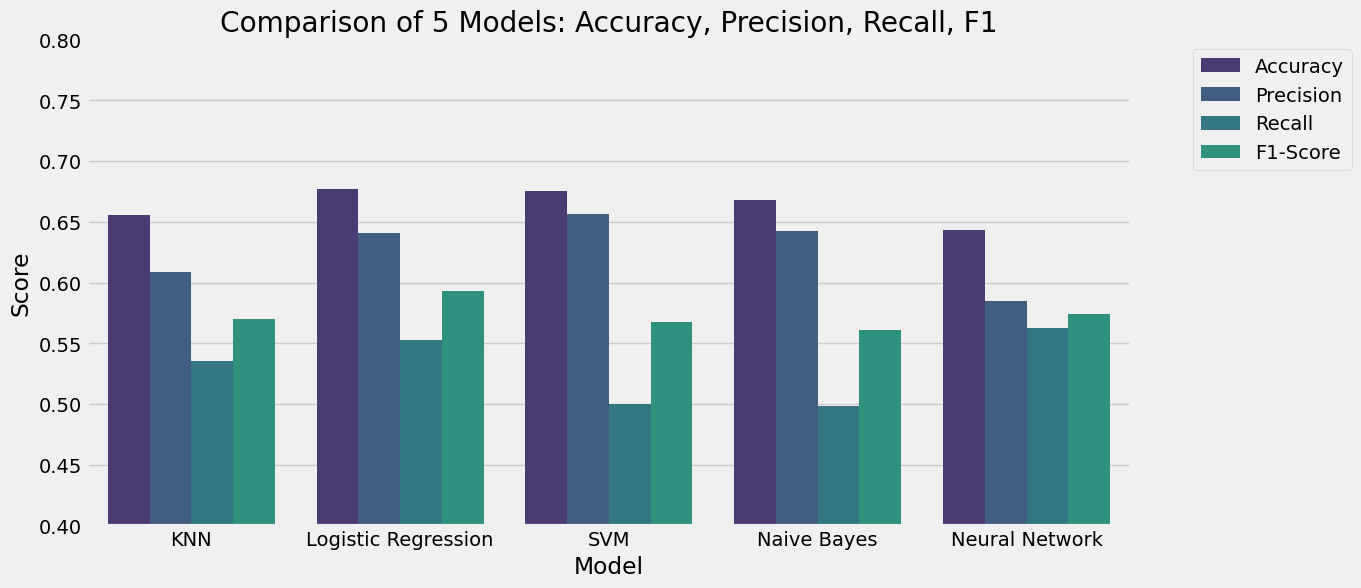

In [3]:
results = []
for name, model in models.items():
    preds = model.predict(X_test_scaled)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds, pos_label='H'),
        "Recall": recall_score(y_test, preds, pos_label='H'),
        "F1-Score": f1_score(y_test, preds, pos_label='H')
    })

perf_df = pd.DataFrame(results).melt(id_vars="Model", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.barplot(data=perf_df, x="Model", y="Score", hue="Metric")
plt.title("Comparison of 5 Models: Accuracy, Precision, Recall, F1")
plt.ylim(0.4, 0.8)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

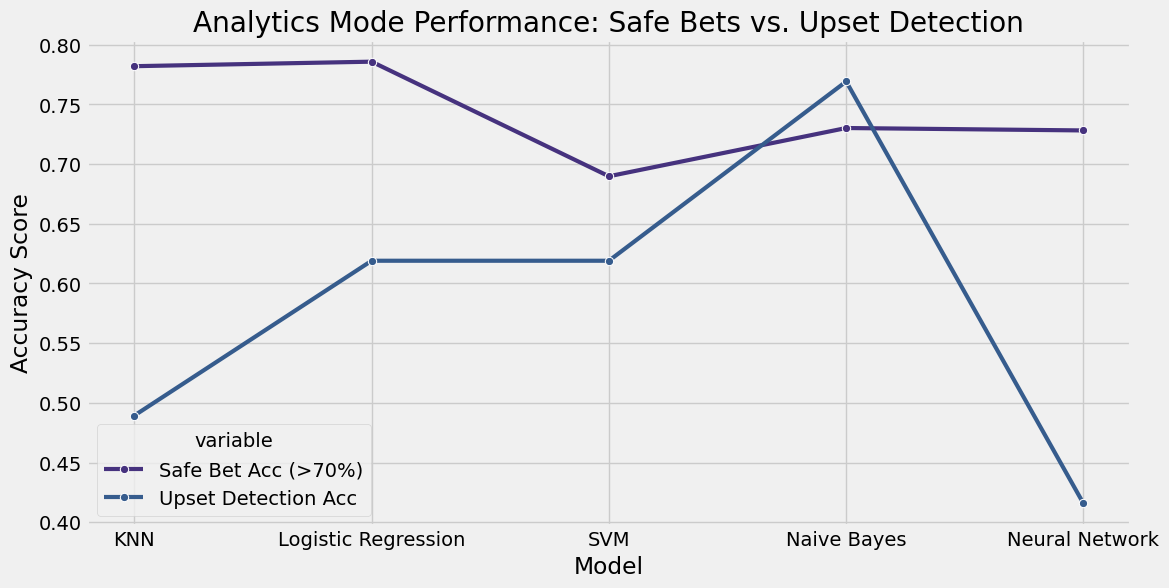

In [4]:
analytics_results = []

for name, model in models.items():
    probs = model.predict_proba(X_test_scaled)[:, 1] # Probability of Home Win
    preds = model.predict(X_test_scaled)
    
    # Question 4: Safe Bet Accuracy (Confidence > 70%)
    safe_mask = (probs > 0.70) | (probs < 0.30)
    if safe_mask.any():
        safe_acc = accuracy_score(y_test[safe_mask], preds[safe_mask])
    else:
        safe_acc = 0
        
    # Question 3: Upset Alert Performance (Model predicts H when Home Team has fewer points)
    upset_mask = (test_df['HTP'] < test_df['ATP']) & (preds == 'H')
    if upset_mask.any():
        upset_acc = accuracy_score(y_test[upset_mask], preds[upset_mask])
    else:
        upset_acc = 0

    analytics_results.append({
        "Model": name,
        "Safe Bet Acc (>70%)": safe_acc,
        "Upset Detection Acc": upset_acc
    })

analysis_df = pd.DataFrame(analytics_results).melt(id_vars="Model")
plt.figure(figsize=(12, 6))
sns.lineplot(data=analysis_df, x="Model", y="value", hue="variable", marker='o', linewidth=3)
plt.title("Analytics Mode Performance: Safe Bets vs. Upset Detection")
plt.ylabel("Accuracy Score")
plt.show()

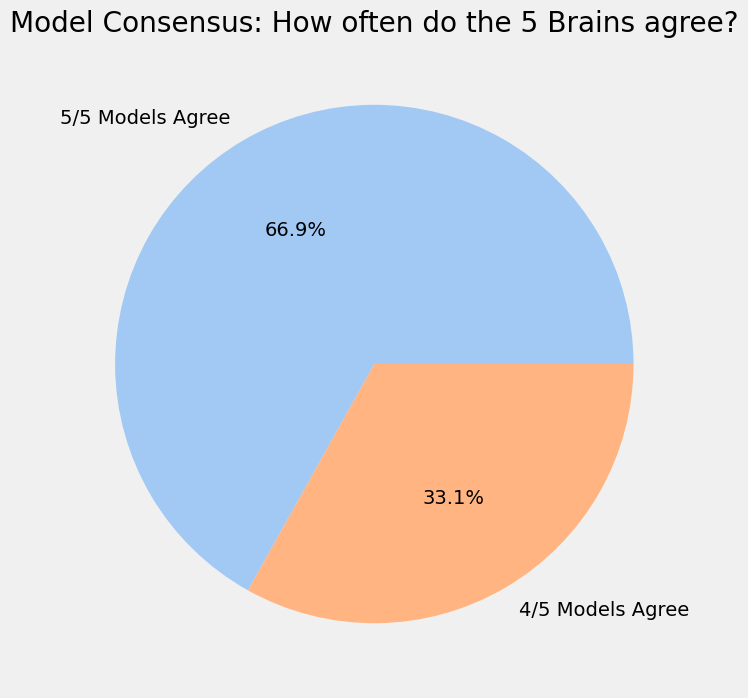

In [5]:
all_preds = pd.DataFrame()
for name, model in models.items():
    all_preds[name] = model.predict(X_test_scaled)

# Calculate agreement
agreement = all_preds.apply(lambda x: x.nunique(), axis=1)
consensus_counts = agreement.value_counts().sort_index()

plt.figure(figsize=(8, 8))
plt.pie(consensus_counts, labels=[f"{6-i}/5 Models Agree" for i in consensus_counts.index], 
        autopct='%1.1f%%', colors=sns.color_palette("pastel"))
plt.title("Model Consensus: How often do the 5 Brains agree?")
plt.show()

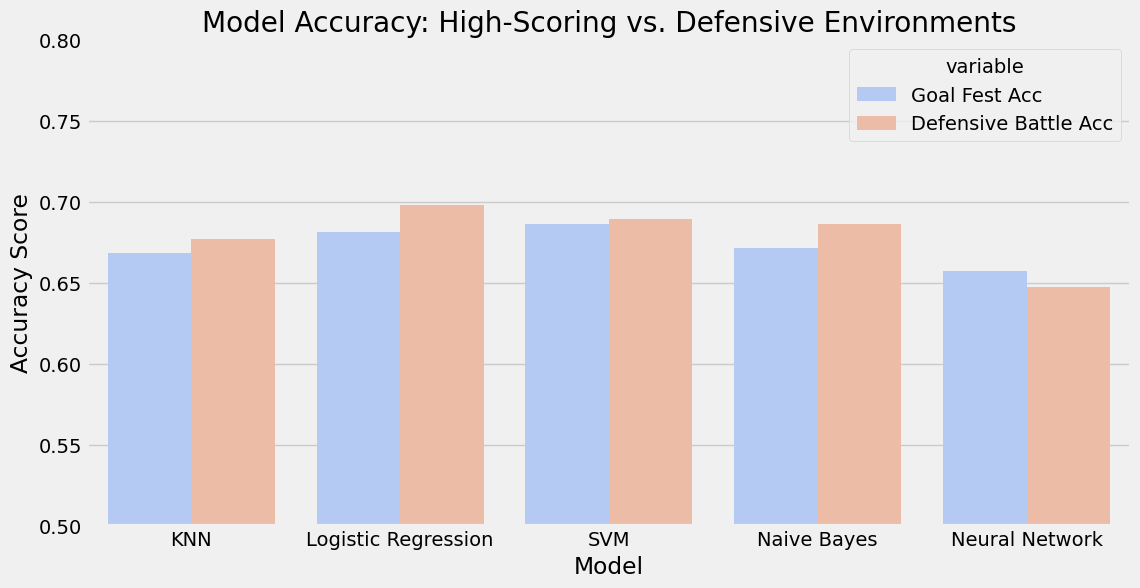

In [6]:
# Mode 5 & 6: Scoring Environment Analytics
env_results = []

# Median thresholds for scoring/conceding
gs_median = test_df['HTGS'].median()
gc_median = test_df['HTGC'].median()

for name, model in models.items():
    preds = model.predict(X_test_scaled)
    
    # Goal Fest: Both teams score more than average
    gf_mask = (test_df['HTGS'] > gs_median) & (test_df['ATGS'] > gs_median)
    # Defensive Battle: Both teams concede less than average
    db_mask = (test_df['HTGC'] < gc_median) & (test_df['ATGC'] < gc_median)
    
    env_results.append({
        "Model": name,
        "Goal Fest Acc": accuracy_score(y_test[gf_mask], preds[gf_mask]),
        "Defensive Battle Acc": accuracy_score(y_test[db_mask], preds[db_mask])
    })

env_df = pd.DataFrame(env_results).melt(id_vars="Model")
plt.figure(figsize=(12, 6))
sns.barplot(data=env_df, x="Model", y="value", hue="variable", palette="coolwarm")
plt.title("Model Accuracy: High-Scoring vs. Defensive Environments")
plt.ylabel("Accuracy Score")
plt.ylim(0.5, 0.8)
plt.show()

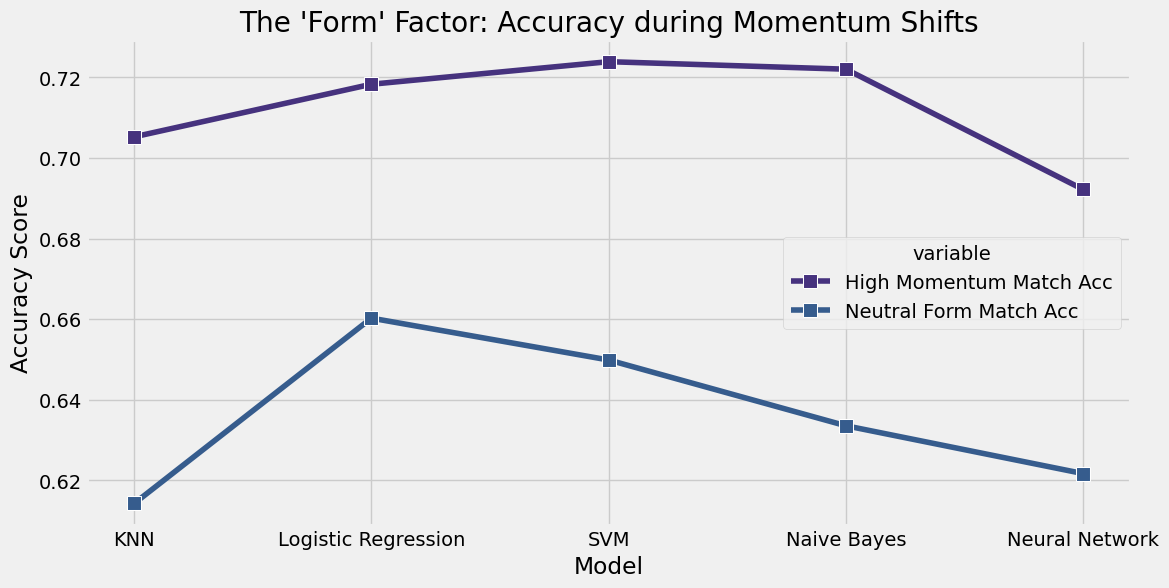

In [7]:
# Mode 7: Form Momentum Impact
form_results = []

for name, model in models.items():
    preds = model.predict(X_test_scaled)
    
    # Significant Form Advantage (Difference > 4 points in last 5 games)
    momentum_mask = abs(test_df['HTFormPts'] - test_df['ATFormPts']) > 4
    # Neutral Form (Difference < 2 points)
    neutral_mask = abs(test_df['HTFormPts'] - test_df['ATFormPts']) <= 2
    
    form_results.append({
        "Model": name,
        "High Momentum Match Acc": accuracy_score(y_test[momentum_mask], preds[momentum_mask]),
        "Neutral Form Match Acc": accuracy_score(y_test[neutral_mask], preds[neutral_mask])
    })

form_df = pd.DataFrame(form_results).melt(id_vars="Model")
plt.figure(figsize=(12, 6))
sns.lineplot(data=form_df, x="Model", y="value", hue="variable", marker='s', markersize=10)
plt.title("The 'Form' Factor: Accuracy during Momentum Shifts")
plt.ylabel("Accuracy Score")
plt.show()

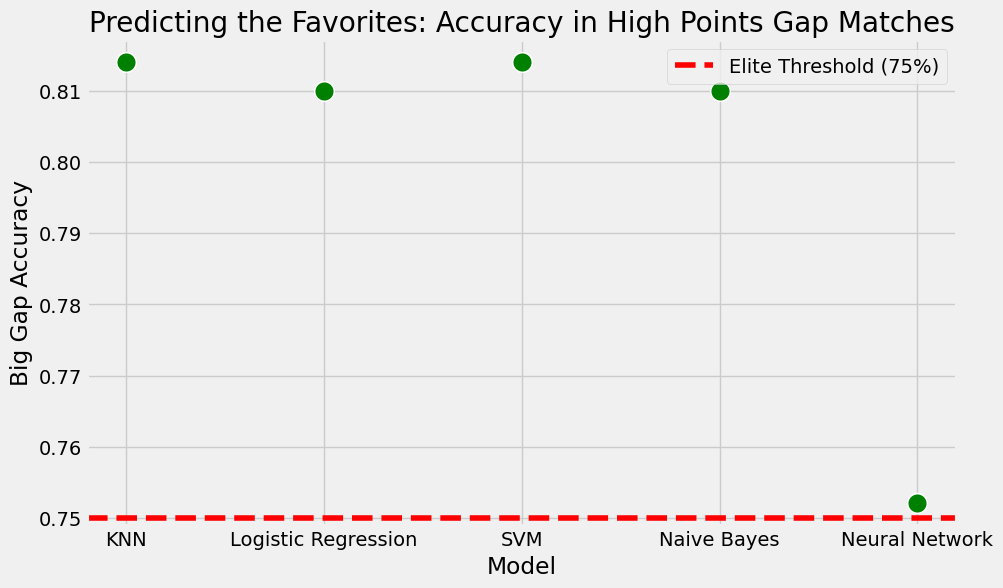

In [8]:
# Mode 8 & 9: Points Gap Analytics
gap_results = []

# Large Gap = Top vs Bottom (Difference > 20 points)
large_gap_mask = abs(test_df['DiffPts']) > 20

for name, model in models.items():
    preds = model.predict(X_test_scaled)
    gap_acc = accuracy_score(y_test[large_gap_mask], preds[large_gap_mask])
    
    gap_results.append({
        "Model": name,
        "Big Gap Accuracy": gap_acc
    })

gap_df = pd.DataFrame(gap_results)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=gap_df, x="Model", y="Big Gap Accuracy", s=200, color='green')
plt.axhline(y=0.75, color='red', linestyle='--', label='Elite Threshold (75%)')
plt.title("Predicting the Favorites: Accuracy in High Points Gap Matches")
plt.legend()
plt.show()